In [2]:
from langchain_unstructured import UnstructuredLoader

loader = UnstructuredLoader(
    file_path="./example.pdf",
    strategy="hi_res",
)
docs = []
for doc in loader.lazy_load():
    docs.append(doc)

/Users/andreasimonecosta/mambaforge/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
INFO: pikepdf C++ to Python logger bridge initialized
INFO: Reading PDF for file: ./example.pdf ...


In [5]:
set = set()

for doc in docs:
  set.add(doc.metadata["category"])

print(set)


{'Table', 'Header', 'UncategorizedText', 'NarrativeText', 'Image', 'ListItem', 'FigureCaption', 'Title', 'Footer'}


In [11]:
images = [doc for doc in docs if doc.metadata["category"] == "Image"]

images

[Document(metadata={'source': './example.pdf', 'detection_class_prob': 0.37476444244384766, 'coordinates': {'points': ((1533.4283447265625, 14.29731559753418), (1533.4283447265625, 75.68260192871094), (1624.34326171875, 75.68260192871094), (1624.34326171875, 14.29731559753418)), 'system': 'PixelSpace', 'layout_width': 1653, 'layout_height': 2339}, 'last_modified': '2024-11-11T16:15:56', 'filetype': 'application/pdf', 'languages': ['eng'], 'page_number': 1, 'file_directory': '.', 'filename': 'example.pdf', 'category': 'Image', 'element_id': '0d861a12a5c4bafbc2b056d719aae207'}, page_content=''),
 Document(metadata={'source': './example.pdf', 'detection_class_prob': 0.45491066575050354, 'coordinates': {'points': ((1523.169677734375, 47.71959686279297), (1523.169677734375, 106.35082244873047), (1612.8466796875, 106.35082244873047), (1612.8466796875, 47.71959686279297)), 'system': 'PixelSpace', 'layout_width': 1653, 'layout_height': 2339}, 'last_modified': '2024-11-11T16:15:56', 'filetype':

TODO: how to properly embed the result of the OCR above? text embedding models aren't enough I would say. We should at least filter out images and other non-text elements, even tho the OCR should have extracted the text into `page_content`.

## Use of multimodal models

Many modern LLMs support inference over multimodal inputs (e.g., images). In some applications-- such as question-answering over PDFs with complex layouts, diagrams, or scans-- it may be advantageous to skip the PDF parsing, instead casting a PDF page to an image and passing it to a model directly. This allows a model to reason over the two dimensional content on the page, instead of a "one-dimensional" string representation.

In [12]:
import base64
import io

import fitz
from PIL import Image

def pdf_page_to_base64(pdf_path: str, page_number: int):
    pdf_document = fitz.open(pdf_path)
    page = pdf_document.load_page(page_number - 1)  # input is one-indexed
    pix = page.get_pixmap()
    img = Image.frombytes("RGB", [pix.width, pix.height], pix.samples)

    buffer = io.BytesIO()
    img.save(buffer, format="PNG")

    return base64.b64encode(buffer.getvalue()).decode("utf-8")

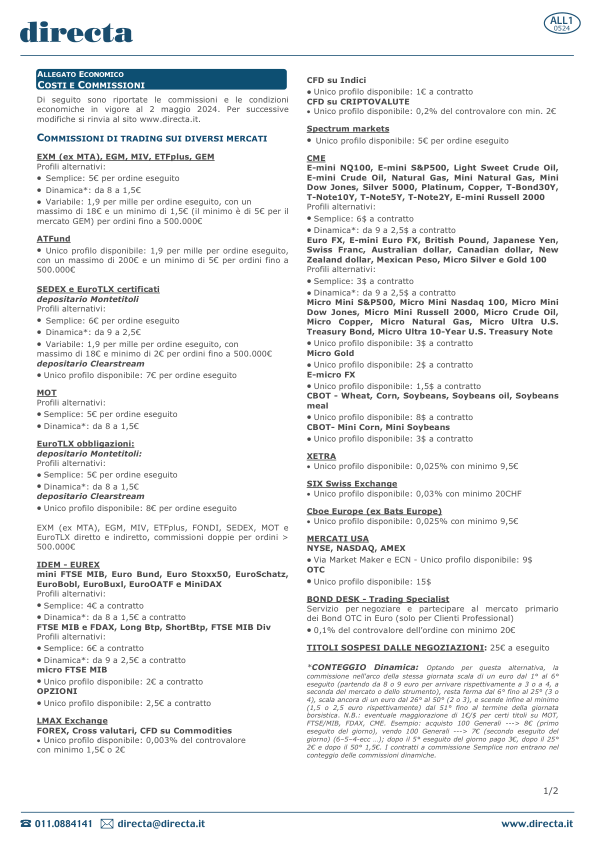

In [17]:
from IPython.display import Image as IPImage
from IPython.display import display

base64_image = pdf_page_to_base64("./example.pdf", 16)
display(IPImage(data=base64.b64decode(base64_image)))

In [15]:
from langchain_ollama import ChatOllama

llm = ChatOllama(
    model="llama3.2-vision",
)

In [ ]:
from langchain_core.messages import HumanMessage

query = "Quali sono le commissioni di trading su EXM?"

message = HumanMessage(
    content=[
        {"type": "text", "text": query},
        {
            "type": "image_url",
            "image_url": {"url": f"data:image/jpeg;base64,{base64_image}"},
        },
    ],
)
response = llm.invoke([message])
print(response.content) # it took 1m 16.2s to run

INFO: HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"


Per i clienti del mercato italiano, la Commissione di Trading per l'EXM è pari a 5€ per ordine.
